In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import tqdm
sns.set()

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Loading data and spliting

In [3]:
import re
def clean_bad_chars(x):
  x = re.sub(r"[^0-9a-zA-Z(!?.)']+", " ", x).strip()
  x = ''.join(" "+i+" " if i in ['!', '?', '.'] else i for i in x).strip()
  return x
def uncover_reduction(x):
  x = re.sub(r"i'm", "i am", x)
  x = re.sub(r"he's", "he is", x)
  x = re.sub(r"she's", "she is", x)
  x = re.sub(r"it's", "it is", x)
  x = re.sub(r"that's", "that is", x)
  x = re.sub(r"what's", "that is", x)
  x = re.sub(r"where's", "where is", x)
  x = re.sub(r"how's", "how is", x)
  x = re.sub(r"\'ll", " will", x)
  x = re.sub(r"\'ve", " have", x)
  x = re.sub(r"\'re", " are", x)
  x = re.sub(r"\'d", " would", x)
  x = re.sub(r"\'re", " are", x)
  x = re.sub(r"won't", "will not", x)
  x = re.sub(r"can't", "cannot", x)
  x = re.sub(r"n't", " not", x)
  x = re.sub(r"n'", "ng", x)
  x = re.sub(r"'bout", "about", x)
  x = re.sub(r"'til", "until", x)
  x = ' '.join(i.replace("'",'') for i in x.split(' ') if i ).strip()
  return x

In [4]:
data_path = '../processed_data'
w2v_embs = True
if w2v_embs:
    with open(os.path.join(data_path,'w2v_embeddings.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_w2v.npy'), 'rb') as f:
        missing = np.load(f)
else:
    with open(os.path.join(data_path,'glove_embeddings.npy'), 'rb') as f:
        final_embeddings = np.load(f)

    with open(os.path.join(data_path,'missing_in_glove.npy'), 'rb') as f:
        missing = np.load(f)
with open(os.path.join(data_path,'token_mapping.json'), 'r') as f:
    token_mapping = json.load(f)

with open(os.path.join(data_path,'data.npy'), 'rb') as f:
    data = np.load(f,allow_pickle=True)  

In [5]:
missing_idx = [token_mapping[i] for i in missing]

In [6]:
len(data)

82957

In [7]:
inverse_token_mapping = dict((v,k) for k,v in token_mapping.items())
pad_token = inverse_token_mapping[0]
start_token = inverse_token_mapping[1]
end_token = inverse_token_mapping[2]
unk_token = inverse_token_mapping[3]

In [8]:
pad_token, start_token, end_token,unk_token

('<pad>', '<start>', '<end>', '<unk>')

In [9]:
test = data[2]
[test[i:i+2] for i in range(0,len(test)-1,1)]

[['no no it is my fault we did not have a proper introduction', 'Cameron .'],
 ['Cameron .',
  'the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .'],
 ['the thing is Cameron i am at the mercy of a particularly hideous breed of loser . my sister . i cannot date until she does .',
  'seems like she could get a date easy enough .']]

In [10]:
def slice_data(data):
    X, y = [], []
    for conversation in data:
        pairs = np.array([conversation[i:i+2] for i in range(0,len(conversation)-1,1)])
        X.extend(list(pairs[:,0]))
        y.extend(list(pairs[:,1]))
    return X, y

In [11]:
X, y = slice_data(data)

In [12]:
len(X), len(y)

(221068, 221068)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20)

In [14]:
len(X_train), len(X_test)

(176854, 44214)

In [15]:
def map_to_ids(x, mapping, end_token=None, start_token=None, padding_token=None, max_len=None):
  if isinstance(x, str):
    x = x.split(' ')
  max_len = max_len if max_len else len(x)
  if start_token:
    x = [start_token] + x
  sent_ids = [mapping[word] for word in x[:max_len]]
  if max_len>len(x):
      if end_token:
        sent_ids.append(mapping[end_token])
      if padding_token:
        sent_ids += [mapping[padding_token]]*(max_len-len(sent_ids))
      return sent_ids
  if end_token:
    sent_ids[-1] = mapping[end_token]
  return sent_ids


In [16]:
max_len_tokens = 20

In [17]:
X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_train])
X_test_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X_test])
X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_train])
X_test_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y_test])
y_train = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in y_train])
y_test = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in y_test])


In [18]:
X_train_dec[0], y_train[0]

(array([    1, 11324,  8654, 13689, 12143, 19650,  5611, 13117,     7,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]),
 array([11324,  8654, 13689, 12143, 19650,  5611, 13117,     7,     2,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]))

# Building a model 

In [19]:
emb_units = 100
lstm_units = 256
attention_units = 128
pretrained_embs = True
fine_tune = False

In [20]:
class PartialEmbeddingsUpdate(tf.keras.layers.Layer):
    def __init__(self, input_dim, 
                 output_dim, 
                indices_to_update,
                initializer='glorot_uniform',
                 **kwargs):
        super(PartialEmbeddingsUpdate, self).__init__(**kwargs)

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.initializer = initializer
        self.indices_to_update = indices_to_update
       
    def build(self, input_shape):
        self.embeddings = self.add_weight(shape=(self.input_dim, self.output_dim),
                                             initializer=self.initializer,
                                            trainable=True)
        self.bool_mask = tf.equal(tf.expand_dims(tf.range(0,self.input_dim),1), tf.expand_dims(self.indices_to_update,0))
        self.bool_mask = tf.reduce_any(self.bool_mask,1)
        self.bool_mask_not = tf.logical_not(self.bool_mask)
        self.bool_mask_not = tf.expand_dims(tf.cast(self.bool_mask_not, dtype=self.embeddings.dtype),1)
        self.bool_mask = tf.expand_dims(tf.cast(self.bool_mask, dtype=self.embeddings.dtype),1)
        
    def call(self, input):
        input = tf.cast(input, dtype=tf.int32)
        embeddings = tf.stop_gradient(self.bool_mask_not * self.embeddings) + self.bool_mask * self.embeddings
        return tf.gather(embeddings,input)
    
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'input_dim' : self.input_dim,
            'output_dim' : self.output_dim,
            'indices_to_update' : self.indices_to_update,
            'initializer' : self.initializer
        })
        return config

In [21]:
missing_indx = tf.constant(missing_idx, dtype=tf.float32)

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units,**kwargs):
    super(BahdanauAttention, self).__init__(**kwargs)
    self.units = units
    self.W1 = tf.keras.layers.Dense(self.units)
    self.W2 = tf.keras.layers.Dense(self.units)
    self.V = tf.keras.layers.Dense(1)


  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

  def get_config(self):

        config = super().get_config().copy()
        config.update({
            'units' : self.units,
        })
        return config

In [23]:
#encoder
enc_input = tf.keras.Input(shape=(None,), name='enc_input')
#shared embedding layer
if not pretrained_embs:
    utter_embedding = tf.keras.layers.Embedding(len(token_mapping), emb_units, name='embedding')
else:
    emb_units = final_embeddings.shape[1]
    if fine_tune:
        utter_embedding = tf.keras.layers.Embedding(len(token_mapping), emb_units, weights=[final_embeddings],
                                  name='embedding')
    else:
        utter_embedding = PartialEmbeddingsUpdate(len(token_mapping),emb_units, missing_idx, weights=[final_embeddings],
                                             name='embeddings')
    
embedded_enc = utter_embedding(enc_input)

encoder = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, name='encoder',
                               dropout=0.3
                               )
encoder_hidden_states, state_h, state_c  = encoder(embedded_enc)

#building encoder model
encoder = tf.keras.Model(enc_input, [encoder_hidden_states, state_h, state_c])
#decoder
dec_input = tf.keras.Input(shape=(None,), name='dec_input')
dec_state_input_h = tf.keras.Input(shape=(lstm_units,), name='state_h')
dec_state_input_c = tf.keras.Input(shape=(lstm_units,), name='state_c')
encoder_hidden_states = tf.keras.Input(shape=(None,lstm_units), name='enc_hidden_states')
#applying attention
attention = BahdanauAttention(attention_units)
context_vector, attention_weights = attention(dec_state_input_h,encoder_hidden_states)
embedded_dec = utter_embedding(dec_input)
inp = tf.concat([tf.expand_dims(context_vector, 1), embedded_dec], axis=-1)
decoder = tf.keras.layers.LSTM(lstm_units, return_sequences=True, return_state=True, name='decoder',
                              dropout=0.3)                               
#giving everything to output layer
decoder_hidden_states,  next_state_h, next_state_c  = decoder(inp,initial_state=[dec_state_input_h, dec_state_input_c])
decoder_hidden_states = tf.reshape(decoder_hidden_states, (-1, decoder_hidden_states.shape[2]))
output_layer = tf.keras.layers.Dense(len(token_mapping), activation='softmax', name='dense_softmax')
result = output_layer(decoder_hidden_states)
decoder = tf.keras.Model([dec_input, dec_state_input_h, dec_state_input_c, encoder_hidden_states],
                         [result, next_state_h, next_state_c, attention_weights])


In [24]:
encoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
enc_input (InputLayer)       [(None, None)]            0         
_________________________________________________________________
embeddings (PartialEmbedding (None, None, 300)         6001200   
_________________________________________________________________
encoder (LSTM)               [(None, None, 256), (None 570368    
Total params: 6,571,568
Trainable params: 6,571,568
Non-trainable params: 0
_________________________________________________________________


In [25]:
decoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
state_h (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
enc_hidden_states (InputLayer)  [(None, None, 256)]  0                                            
__________________________________________________________________________________________________
bahdanau_attention (BahdanauAtt ((None, 256), (None, 65921       state_h[0][0]                    
__________________________________________________________________________________________________
dec_input (InputLayer)          [(None, None)]       0                                            
____________________________________________________________________________________________

decoder


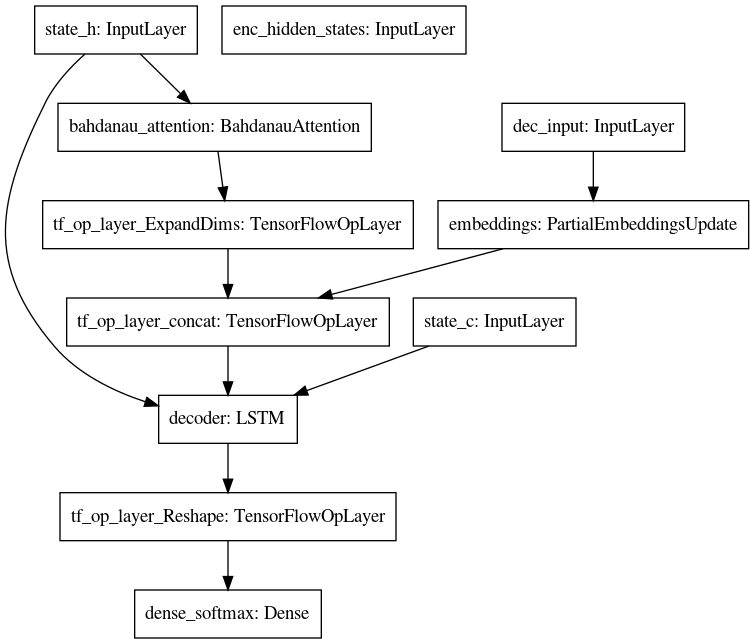

In [26]:
from tensorflow.keras.utils import plot_model
print('decoder')
plot_model(decoder)


encoder


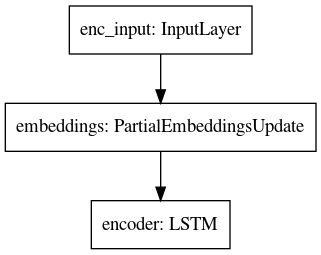

In [27]:
print('encoder')
plot_model(encoder)

# Some helpful stuff

In [28]:
def decode_sequence(x, greedy=False):
    encoder_hidden_states, state_h, state_c = encoder(np.expand_dims(x,axis=0))

    start = token_mapping[start_token]
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = token_mapping[start_token]


    stop_condition = False
    decoded_sentence = ''
    res=[]
    while True:
        # Sample a token
          output, state_h, state_c, attention_weights = decoder([target_seq, 
                                                                        state_h, 
                                                                        state_c,
                                                                        encoder_hidden_states])
          output = np.hstack(output)          
          if greedy:
            sampled_token_index = np.argmax(output)
          else:  
            sampled_token_index = np.random.choice(range(len(output)), size=1, p=output)[0]

          if (len(res) > max_len_tokens or sampled_token_index==token_mapping[end_token]):
              break
                
          res.append(sampled_token_index)

          target_seq = np.zeros((1, 1))
          target_seq[0, 0] = sampled_token_index

    return res

In [29]:
def beam_search_predictions(x, beam_size = 3):
    start = [token_mapping[start_token]]
    encoder_hidden_states, state_h, state_c = encoder(np.expand_dims(x,axis=0))
    
    start_word = [[start, 0.0, state_h, state_c]]
    
    
    while len(start_word[0][0]) < max_len_tokens:
        temp = []
        for s in start_word:
            target_seq = np.array([[s[0][-1]]])
            state_h = s[2]
            state_c = s[3]
            output, state_h, state_c, attention_weights = decoder([target_seq, 
                                                                        state_h, 
                                                                        state_c,
                                                                        encoder_hidden_states])
            output = np.hstack(output)
            
            word_preds = np.argsort(output)[-beam_size:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += output[w]
                temp.append([next_cap, prob, state_h, state_c,])
                    
        start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_size:]
    
    start_word = start_word[-1][0]

    final_caption = []
    
    for i in start_word:
        if i != token_mapping[end_token]:
            final_caption.append(i)
        else:
            break    
    return final_caption[1:]

In [30]:
def process(x, unk_token):
  res = []
  for i in x.split(' '):
    if token_mapping.get(i):
      res.append(i)
    elif token_mapping.get(i.lower()):
      res.append(i.lower())
    else:
      res.append(unk_token)
  return res

In [31]:
def give_answer(sentence, pad_unk=True, process_sentence=True, greedy=False,
               beam_search=False, beam_size=2):
  if process_sentence:
    cleaned_sentence = uncover_reduction(clean_bad_chars(sentence))
    unk_token = pad_token if pad_unk else "<unk>"
    processed_sentence = process(cleaned_sentence, unk_token)
    mapped_sentence = map_to_ids(processed_sentence, token_mapping, end_token, padding_token=pad_token, max_len=max_len_tokens)
  else:
    mapped_sentence = sentence
  if not beam_search:
      prediction = decode_sequence(mapped_sentence,greedy)
  else:
      prediction = beam_search_predictions(mapped_sentence, beam_size)
  answer = " ".join([inverse_token_mapping.get(i) for i in prediction]).capitalize()
  return answer
  

In [32]:
res = decode_sequence(X_test_enc[13], True)
res

[11122,
 11122,
 11122,
 11122,
 16607,
 1175,
 3283,
 18594,
 18594,
 18594,
 18594,
 19781,
 19781,
 9235,
 1981,
 15742,
 12207,
 12207,
 14769,
 4806,
 14039]

In [33]:
res = beam_search_predictions(X_test_enc[13], 7)
res

[2113,
 6034,
 6034,
 6034,
 4542,
 1359,
 1359,
 2836,
 2836,
 16593,
 140,
 19691,
 11500,
 2970,
 4420,
 3058,
 3752,
 3173,
 17163]

# Training

In [34]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, token_mapping[pad_token]))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [35]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [36]:
@tf.function
def evaluate(encoder_input, decoder_input, target):
    loss = 0
    enc_hidden_states, state_h, state_c  = encoder(encoder_input)
    # Teacher forcing - feeding the target as the next input
    for t in range(decoder_input.shape[1]):
      # passing enc_output to the decoder
      dec_input = tf.expand_dims(decoder_input[:, t], 1) 
      result, state_h, state_c, attention_weights = decoder([dec_input, 
                                                             state_h, 
                                                             state_c, 
                                                             enc_hidden_states])
      

      loss += loss_function(target[:, t], result)
    batch_loss = (loss / int(target.shape[1]))
    batch_perplexity = tf.exp(batch_loss)
    return batch_loss, batch_perplexity

In [37]:
@tf.function
def train_step(encoder_input, decoder_input, target):
  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden_states, state_h, state_c  = encoder(encoder_input)
    # Teacher forcing - feeding the target as the next input
    for t in range(decoder_input.shape[1]):
      # passing enc_output to the decoder
      dec_input = tf.expand_dims(decoder_input[:, t], 1) 
      result, state_h, state_c, attention_weights = decoder([dec_input, 
                                                             state_h, 
                                                             state_c, 
                                                             enc_hidden_states])
      

      loss += loss_function(target[:, t], result)


  batch_loss = (loss / int(target.shape[1]))
  batch_perplexity = tf.exp(batch_loss)


  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)


  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss, batch_perplexity

In [38]:
batch_size = 256

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_enc, X_train_dec, y_train)).shuffle(len(X_train_enc))
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

test_datest = tf.data.Dataset.from_tensor_slices((X_test_enc, X_test_dec, y_test)).shuffle(len(X_test_enc))
test_datest = test_datest.batch(batch_size, drop_remainder=True)

In [ ]:
from datetime import datetime
now_date = datetime.strftime(datetime.now(), "%Y-%m-%d")
steps_per_epoch = X_train_enc.shape[0]//batch_size
epochs = 300
cut_epoch = 10
train_loss = []
val_loss = []
train_perplexity = []
val_perplexity = []
val_loss_bound = 0
epochs_overfit = 0
for epoch in tqdm.tqdm(range(epochs)):
    total_train_loss = []
    total_val_loss = []
    total_train_perplexity = []
    total_val_perplexity = []
    
    for batched_x_enc, batched_x_dec, batched_y in train_dataset.take(steps_per_epoch):
        batch_loss, batch_perplexity = train_step(np.array(batched_x_enc),np.array(batched_x_dec), np.array(batched_y))
        total_train_loss.append(batch_loss)
        total_train_perplexity.append(batch_perplexity)
        
    total_train_perplexity = np.mean(total_train_perplexity)
    total_train_loss = np.mean(total_train_loss)
    
    print('\n')
    print('Epoch {} train loss {:.4f} train perplexity {:.4f}'.format(epoch,
                                      total_train_loss, total_train_perplexity))
    
    for batched_x_test_enc, batched_x_test_dec, batched_test_y in test_datest.take(steps_per_epoch):
        batch_loss, batch_perplexity = evaluate(np.array(batched_x_test_enc),np.array(batched_x_test_dec), np.array(batched_test_y))
        total_val_loss.append(batch_loss)
        total_val_perplexity.append(batch_perplexity)
        
    total_val_perplexity = np.mean(total_val_perplexity)
    total_val_loss = np.mean(total_val_loss)
    
    if epoch==0:
        val_loss_bound = total_val_loss
        
    if total_val_loss>val_loss_bound:
        epochs_overfit+=1
        encoder.save('../models/encoder_date:{}_fine_tune:{}_w2v:{}_epoch:{}.h5'.format(now_date, fine_tune,w2v_embs, epoch,))
        decoder.save('../models/decoder_date:{}_fine_tune:{}_w2v:{}_epoch:{}.h5'.format(now_date,fine_tune,w2v_embs,epoch))
    else:
        val_loss_bound=total_val_loss
        epochs_overfit=0
    
        
    print('\n')
    print('Epoch {} validation loss {:.4f} validation perplexity {:.4f}'.format(epoch,
                                                            total_val_loss,
                                                             total_val_perplexity))
    print('\n')
    
    train_loss.append(total_train_loss)
    train_perplexity.append(total_train_perplexity)
    val_loss.append(total_val_loss)
    val_perplexity.append(total_val_perplexity)
    
    if epoch%5==0:
      test_sentences = np.random.choice(X_test_enc.shape[0], 5)
      test_sentences = X_test_enc[test_sentences]
      for sentence in test_sentences:
        print(30*'-')
        print('Test sentence : {}'.format(' '.join([inverse_token_mapping.get(i) for i in sentence])))
        answer = give_answer(sentence,process_sentence=False, beam_search=True, beam_size=3)
        print("Model answer : {}".format(answer))
        print(30*'-')
        
    if epochs_overfit==cut_epoch:
       print('Validation loss has not improved for last {} epochs, stopping training!'.format(epoch))
       break

  0%|          | 0/300 [00:00<?, ?it/s]



Epoch 0 train loss 2.9163 train perplexity 20.4418


Epoch 0 validation loss 2.6307 validation perplexity 13.9757


------------------------------
Test sentence : naw naw that is too much exposure . i ai not goin anywhere near that money . <end> <pad> <pad>
Model answer : I do not know you .
------------------------------
------------------------------
Test sentence : the money ! <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : I do not know you .
------------------------------
------------------------------
Test sentence : get out ! me too ! what are the odds ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : I do not know you .
------------------------------
------------------------------
Test sentence : wait ! hold it it is on . lets go . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : I do not know you .
------------------------------
------------------------------
Test se

  0%|          | 1/300 [04:42<23:26:31, 282.24s/it]

Model answer : I do not know it .
------------------------------


Epoch 1 train loss 2.5303 train perplexity 12.6332


  1%|          | 2/300 [09:08<22:36:13, 273.06s/it]



Epoch 1 validation loss 2.4837 validation perplexity 12.0485




Epoch 2 train loss 2.4236 train perplexity 11.3406


  1%|          | 3/300 [13:36<22:18:57, 270.50s/it]



Epoch 2 validation loss 2.4209 validation perplexity 11.3204




Epoch 3 train loss 2.3611 train perplexity 10.6575


  1%|▏         | 4/300 [18:05<22:11:53, 269.98s/it]



Epoch 3 validation loss 2.3825 validation perplexity 10.8832




Epoch 4 train loss 2.3134 train perplexity 10.1552


  2%|▏         | 5/300 [22:42<22:19:41, 272.48s/it]



Epoch 4 validation loss 2.3561 validation perplexity 10.6105




Epoch 5 train loss 2.2743 train perplexity 9.7666


Epoch 5 validation loss 2.3373 validation perplexity 10.4054


------------------------------
Test sentence : you sure it was him ? <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : do not let your fathers business infect your life . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : you were talking about your wedding . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Model answer : I do not know .
------------------------------
------------------------------
Test sentence : going after killers is not the same as chasing <unk> Eric . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Mo

  2%|▏         | 6/300 [27:18<22:20:24, 273.55s/it]

Model answer : What ?
------------------------------


Epoch 6 train loss 2.2409 train perplexity 9.4392


  2%|▏         | 7/300 [31:45<22:06:42, 271.68s/it]



Epoch 6 validation loss 2.3241 validation perplexity 10.2684




Epoch 7 train loss 2.2114 train perplexity 9.1665


  3%|▎         | 8/300 [36:19<22:04:29, 272.15s/it]



Epoch 7 validation loss 2.3148 validation perplexity 10.1719




Epoch 8 train loss 2.1839 train perplexity 8.9200


  3%|▎         | 9/300 [40:52<22:01:40, 272.51s/it]



Epoch 8 validation loss 2.3085 validation perplexity 10.1065




# Training history plot

In [ ]:
plt.figure(figsize=(15,12))
plt.plot(train_perplexity)
plt.plot(val_perplexity)
plt.yticks(np.arange(min(train_perplexity), max(train_perplexity),0.5))
plt.legend(['Train perplexity','Val perplexity'])
plt.title('Perplexity ');

In [ ]:
plt.figure(figsize=(15,12))
plt.plot(train_loss)
plt.plot(val_loss)
plt.yticks(np.arange(min(train_loss), max(train_loss),0.1))
plt.legend(['Train loss','Val loss'])
plt.title('Loss ');

# Loading the model

In [41]:
encoder = tf.keras.models.load_model('../models/encoder_date:2021-02-22_fine_tune:False.h5', 
                                     custom_objects={"PartialEmbeddingsUpdate" : PartialEmbeddingsUpdate})
decoder = tf.keras.models.load_model('../models/decoder_date:2021-02-22_fine_tune:False.h5',
                                    custom_objects={"PartialEmbeddingsUpdate" : PartialEmbeddingsUpdate,
                                                   "BahdanauAttention":BahdanauAttention})

# Dialogue generation and question answering

In [45]:
replicas = ['hey you!',
            'hello',
            'hi',
            'how are you?',
            'have you ever been to USA?',
            'where are you from?',
            'what do you think about marriage?',
             'I need your help',
           'Where do you recommend me to go?',
           'you are under arrest!',
           'want to fuck me?']
for i in replicas:
    greedy_answer = give_answer(i, greedy=True)
    sampled_answer = give_answer(i, greedy=False)
    beam_search_answer = give_answer(i, beam_search=True, beam_size=3)
    print(30*'-')
    print('Test replica : {}'.format(i))
    print('Bot greedy answer : {}'.format(greedy_answer))
    print('Bot sampled answer : {}'.format(sampled_answer))
    print('Bot beam search answer : {}'.format(beam_search_answer))
    print(30*'-')


------------------------------
Test replica : hey you!
Bot greedy answer : i am sorry .
Bot sampled answer : okay .
Bot beam search answer : what ?
------------------------------
------------------------------
Test replica : hello
Bot greedy answer : i am sorry .
Bot sampled answer : Baxter Mr th handshake . my names Worf i heard them .
Bot beam search answer : hi .
------------------------------
------------------------------
Test replica : hi
Bot greedy answer : hi .
Bot sampled answer : Harold .
Bot beam search answer : what ?
------------------------------
------------------------------
Test replica : how are you?
Bot greedy answer : i am not going to get you .
Bot sampled answer : Ruiz knows knows where gets in something alive . he is a better .
Bot beam search answer : i do not know .
------------------------------
------------------------------
Test replica : have you ever been to USA?
Bot greedy answer : no .
Bot sampled answer : sure . i can get with cabins and maybe uhm aroun

In [49]:
inp = ''
while True:
    inp = str(input()).strip()
    if inp=='exit':
        break
    greedy_answer = give_answer(inp, True, greedy=False, beam_search=True,
                               beam_size=2)
    print(30*'-')
    print('Replica : {}'.format(inp))
    print('Answer : {}'.format(greedy_answer))
    print(30*'-')

hello
------------------------------
Replica : hello
Answer : hi .
------------------------------
how are you?
------------------------------
Replica : how are you?
Answer : i do not know .
------------------------------
do you want to take a walk?
------------------------------
Replica : do you want to take a walk?
Answer : no .
------------------------------
where are you from>
------------------------------
Replica : where are you from>
Answer : i do not know .
------------------------------
where are we?
------------------------------
Replica : where are we?
Answer : we are not going to get out .
------------------------------


KeyboardInterrupt: Interrupted by user